In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgn
import scipy.optimize as opt
import bisect

This is a quick demo of my ACF stamp routine used to fit Gaussians.

In [66]:
def gaussian(x, sig, mu):
    curve = np.exp(-0.5*((x - mu)/sig)**2)/(sig*np.sqrt(2*np.pi))
    curve /= max(curve)
    return curve

In [67]:
def sinc(x):

    return np.sin(x) / x

Text(0, 0.5, 'Sum Over Other Lag')

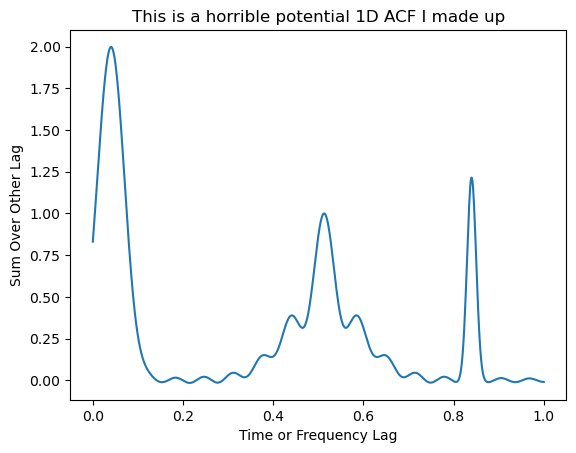

In [68]:
xs = np.linspace(0, 1, 1024)
lag_sum = 0.5*sinc(100 * (xs - 0.513)) + 0.5*gaussian(xs, 0.08, 0.513) \
      + 2*gaussian(xs, 0.03, 0.04) + 1.2*gaussian(xs, 0.01, 0.84)
plt.title('This is a horrible potential 1D ACF I made up')
plt.plot(xs, lag_sum)
plt.xlabel('Time or Frequency Lag')
plt.ylabel('Sum Over Other Lag')

We're going to limit our search for a peak to the central 10% of the range, so we don't go chasing after noise at the extremities.

In [ ]:
search_range = np.where(np.abs(np.arange(len(lag_sum)) / len(lag_sum) - 0.5) < 0.1)[0]
max_idx = np.where(lag_sum == max(lag_sum[search_range]))[0]
if len(max_idx) > 1:
    max_idx = max_idx[0]
xs[max_idx]

array([0.51319648])

Yay! That's the central value we put in!

Now we're going to find the local minima in our 1D ACF.

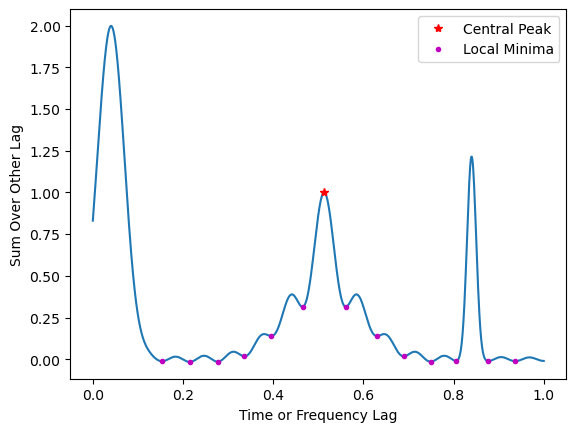

In [69]:
minima = sgn.argrelmin(lag_sum)
plt.plot(xs, lag_sum)
plt.plot(xs[max_idx], lag_sum[max_idx], 'r*', label = 'Central Peak')
plt.plot(xs[minima], lag_sum[minima], 'm.', label = 'Local Minima')
plt.xlabel('Time or Frequency Lag')
plt.ylabel('Sum Over Other Lag')
plt.legend()

Great. Let's pick the two local minima on either side of our peak as the bounds for the part of the ACF we'll fit.

In [70]:
def find_boundaries(A, B):
    idx = bisect.bisect_left(A, B)
    if idx == 0 or idx == len(A):
        print("There's something really weird with this observation.")
    else:
        return A[idx-1], A[idx]

low, high = find_boundaries(minima[0], max_idx)
xs[low], xs[high]


(0.46529814271749753, 0.5610948191593352)

We're only going to use this portion of the ACF for our stamp. Skipping the stuff with plotting in 2D, let's take a look at our 1D stamp. We're going to replace the peak value with the median of the values on either side of it, since there's often a spike in the ACF at zero-lag. Then we'll fit a Gaussian.

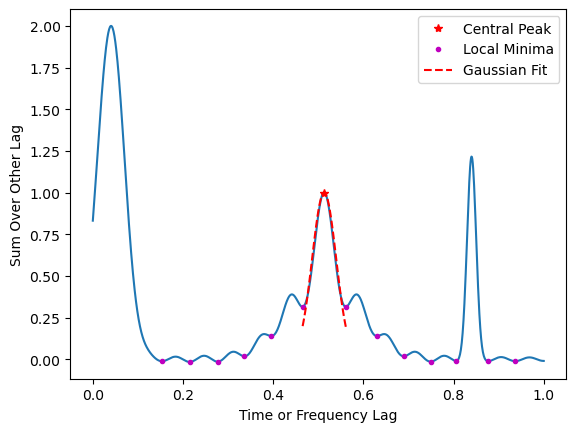

In [56]:
lag_sum[max_idx] = (lag_sum[max_idx - 1] + lag_sum[max_idx + 1]) / 2
lag_sum /= lag_sum[max_idx]
sig, mu = opt.curve_fit(gaussian, xs[low:high + 1], lag_sum[low:high+1], 
                        [0.05*xs[-1], 0.5*xs[-1]])[0]
plt.plot(xs, lag_sum)
plt.plot(xs[max_idx], lag_sum[max_idx], 'r*', label = 'Central Peak')
plt.plot(xs[minima], lag_sum[minima], 'm.', label = 'Local Minima')
plt.plot(xs[low:high+1], gaussian(xs[low:high + 1], sig, mu), 'r--', label = 'Gaussian Fit')
plt.xlabel('Time or Frequency Lag')
plt.ylabel('Sum Over Other Lag')
plt.legend()

And finally, our FWHM will be $2 \sqrt{2\ln{2}} \sigma$:

In [65]:
fwhm_conv = 2*np.sqrt(2 * np.log(2))
fwhm = fwhm_conv * sig
print(f'FWHM = {fwhm}')

FWHM = 0.06250087069536896


Or we could just do all of this with my handy module `fitACF`!

In [64]:
import fitACF
fwhm = fitACF.get_fwhm(xs, lag_sum)[0]
print(f'FWHM = {fwhm}')

FWHM = 0.06257701607938937
